In [3]:
from launcher import *
from interface import *
from geone.imgplot import drawImage2D
import os
os.chdir(r"C:\Users\Axel (Travail)\Documents\Cesure\UWA\CET\GeoclassificationMPS")
print("Répertoire courant :", os.getcwd())

Répertoire courant : C:\Users\Axel (Travail)\Documents\Cesure\UWA\CET\GeoclassificationMPS


In [19]:
verbose=True
arg_seed=789
arg_n_ti=1
arg_ti_pct_area=75
arg_num_shape=1
arg_aux_vars=["grid_mag","grid_lmp","grid_grv"]
arg_output_dir="./output/base_case"

In [20]:
def get_simulation_info_custom(arg_seed = None, arg_n_ti = None, arg_ti_pct_area = None, arg_num_shape = None, arg_aux_vars = None, arg_output_dir = "./output"):
    
    ##################### LOCATIONS OF THE CSV DATA FILE #####################
    
    csv_file_path = "./data/data_csv.csv" # MAKE THIS PARAM MORE ACCESSIBLE
    
    # Expected CSV File Format (Columns are separataed by ","):
    #
    # The CSV file should contain information about variables to be loaded as numpy arrays.
    # Each line in the CSV file should be formatted as follows:
    #
    # Column 1: var_name      - The name of the variable.
    # Column 2: categ_conti   - The type of variable, either "categorical" or "continuous".
    # Column 3: nature        - Indicates whether the variable is a simulated ("sim") variable, auxiliary descriptive ("auxTI") variable, auxiliary conditioning ("auxSG"), or conditioning image ("condIm") variable.
    # Column 4: path          - The full file path to the .npy file containing the numpy array data. (format .npy and the array must be in 2 dimensions)
    # Column 5: grid          - The grid where the varaible will be loaded ("TI" or "SG")
    #
    # Example (first line contains headers):
    #
    # var_name,categ_conti,nature,path,grid
    # grid_geo,categorical,sim,C:\path\to\grid_geo_sim.npy,TI
    # grid_grv,continuous,auxTI,C:\path\to\grid_grv.npy,TI
    # grid_grv,continuous,auxSG,C:\path\to\grid_grv.npy,SG
    # grid_lmp,continuous,auxTI,C:\path\to\grid_lmp.npy,TI
    # grid_lmp,continuous,auxSG,C:\path\to\grid_lmp.npy,SG
    # grid_mag,continuous,auxTI,C:\path\to\grid_mag.npy,TI
    # grid_mag,continuous,auxSG,C:\path\to\grid_mag.npy,SG
    # grid_geo,categorical,condIm,C:\path\to\grid_geo_cond.npy,SG
    # auxiliary,continuous,auxTI,C:\path\to\auxTI.npy,TI
    # auxiliary,continuous,auxSG,C:\path\to\auxSG.npy,SG
         
    ##################### RANDOM PARAMETERS #####################

    seed = arg_seed

    ##################### NOVALUE #####################

    novalue = -9999999

    ##################### TRAINING IMAGE PARAMETERS #####################
    
    # The available methods are :
    # "DependentCircles", "DependentSquares", "IndependentSquares", "Customised", "ReducedTiSg"
    ti_methods = ["DependentSquares"] #List of methods
    
    #Parameters for "DependentCircles", "DependentSquares", "IndependentSquares"
    ti_pct_area = arg_ti_pct_area
    ti_nshapes = arg_num_shape

    #Parameters for "Customised"
    custom_mask_path ="./data/custom_mask.npy" #if no mask, please write None.
    
    #Parameters for "ReducedTiSg"
    pct_ti_sg_overlap=50  
    pct_sg=30
    pct_ti=70
    cc_sg=None #Number of columns of the simulation grid
    rr_sg=None #Number of rows of the simulation grid
    cc_ti=None #Number of columns of the training image
    rr_ti=None #Number of rows of the training image
    
    #Number of random TI and CD sets to generate a simulation with
    nRandomTICDsets = arg_n_ti
    
    ##################### DEESSE SIMULATION PARAMETERS #####################

    nn = 24  # Number of neighboring nodes
    dt = 0.1  # Distance threshold
    ms = 0.25  # Maximum scan fraction
    numberofmpsrealizations = 5  # Number of Deesse realizations
    nthreads = 4  # Number of threads for parallel processing
    
    ##################### OUTPUT PARAMETERS #####################
    
    #---- To turn On or Off the saving of the output ----#
    saveMask = True #To save each mask used for each simulation
    saveOutput = True #Only for the DeeSse Output
    saveIndicators = True #For the indicators and the standard deviation of the indicators
    
    output_directory = arg_output_dir #"../output"  # TO DO MAKE THIS PARAM MORE ACCESSIBLE
    
    deesse_output_folder = "deesse_output"
    prefix_deesse_output = "simulation"
    
    plot_output_folder = "variability/"+str(arg_aux_vars)
    prefix_histogram_dissimilarity = "jensen_shannon_divergence"
    prefix_entropy = "entropy"
    prefix_simvar_histograms = "histograms"
    prefix_topological_adjacency = "topological_adjacency"
    prefix_proportions = "proportions"
    prefix_std_deviation = "std_deviation"
    reference_var = np.load("./data/grid_geo.npy") # TO DO MAKE THIS PARAM MORE ACCESSIBLE 
    
    ##################### SHORTEN THE SIMULATION #####################

    shorten = False
    
    ##################### PICKING SIM AND AUX VAR #####################
    
    check_ti_methods(ti_methods)
    
    auxTI_var_temp, auxSG_var_temp, condIm_var, sim_var, names_var, types_var, outputVarFlag = create_variables(csv_file_path)
    auxTI_var_temp, auxSG_var_temp, condIm_var, sim_var = check_variables(sim_var, auxTI_var_temp, auxSG_var_temp, condIm_var, names_var, types_var, novalue)
    
    ############################################################################################################
    ### MOVE THAT INTO A FUNCTION ##############################################################################
    ############################################################################################################
    auxTI_var = {key: value for key, value in auxTI_var_temp.items() if key in arg_aux_vars}
    auxSG_var = {key: value for key, value in auxSG_var_temp.items() if key in arg_aux_vars}
    outputVarFlag = {key: value for key, value in outputVarFlag.items() if key in arg_aux_vars}
    outputVarFlag["grid_geo"]=True
    names_var = [arg_aux_vars,arg_aux_vars,[],["grid_geo"]]
    types_var[1], types_var[2] = types_var[1][:len(arg_aux_vars)], types_var[2][:len(arg_aux_vars)]
    ############################################################################################################

    nvar = count_variables(names_var)
    
    nr, nc = get_sim_grid_dimensions(sim_var)

    params = {
        'seed': seed,
        'csv_file_path': csv_file_path,
        'novalue': novalue,
        'sim_var': list(sim_var.keys()),
        'auxTI_var': list(auxTI_var.keys()),
        'auxSG_var': list(auxSG_var.keys()),
        'condIm_var':list(condIm_var.keys()),
        'ti_methods': ti_methods,
        'ti_pct_area': ti_pct_area,
        'ti_nshapes': ti_nshapes,
        'pct_ti_sg_overlap': pct_ti_sg_overlap,
        'pct_sg': pct_sg,
        'pct_ti': pct_ti,
        'cc_sg': cc_sg,
        'rr_sg': rr_sg,
        'cc_ti': cc_ti,
        'rr_ti': rr_ti,
        'custom_mask_path':custom_mask_path,
        'nRandomTICDsets': nRandomTICDsets,
        'n_neighbouring_nodes': nn,
        'distance_threshold': dt,
        'max_scan_fraction': ms,
        'n_mps_realizations': numberofmpsrealizations,
        'n_threads': nthreads,
        'saveMask':saveMask,
        'saveOutput': saveOutput,
        'saveIndicators': saveIndicators,
        'output_directory': output_directory,
        'deesse_output_folder': deesse_output_folder,
        'prefix_deesse_output': prefix_deesse_output,
        'plot_output_folder': plot_output_folder,
        'prefix_histogram_dissimilarity': prefix_histogram_dissimilarity,
        'prefix_entropy': prefix_entropy,
        'prefix_simvar_histograms': prefix_simvar_histograms,
        'prefix_topological_adjacency': prefix_topological_adjacency,
        'prefix_proportions': prefix_proportions,
        'prefix_std_deviation' : prefix_std_deviation,
        'reference_var': reference_var,        
        }
    
    return params, \
            shorten, \
            nvar, sim_var, auxTI_var, auxSG_var, condIm_var, names_var, types_var, outputVarFlag, \
            nr, nc 

In [21]:
params, \
shorten, \
nvar, sim_var, auxTI_var, auxSG_var, condIm_var, names_var, types_var, outputVarFlag, \
nr, nc = get_simulation_info_custom(arg_seed, arg_n_ti, arg_ti_pct_area, arg_num_shape, arg_aux_vars, arg_output_dir)

In [22]:
seed = params['seed'] 
ti_methods = params['ti_methods']
ti_pct_area = params['ti_pct_area']
ti_nshapes = params['ti_nshapes']
pct_ti_sg_overlap = params['pct_ti_sg_overlap']
pct_sg = params['pct_sg']
pct_ti = params['pct_ti'] 
cc_sg = params['cc_sg']
rr_sg = params['rr_sg']
cc_ti = params['cc_ti']
rr_ti = params['rr_ti']
custom_mask_path = params['custom_mask_path']
nRandomTICDsets = params['nRandomTICDsets']
nn = params['n_neighbouring_nodes']
dt = params['distance_threshold']
ms = params['max_scan_fraction']
numberofmpsrealizations = params['n_mps_realizations']
nthreads = params['n_threads']
saveMask = params['saveMask']
saveOutput = params['saveOutput']
saveIndicators = params['saveIndicators']
output_directory = params['output_directory']
deesse_output_folder = params['deesse_output_folder']
prefix_deesse_output = params['prefix_deesse_output']
plot_output_folder = params['plot_output_folder']
prefix_histogram_dissimilarity = params['prefix_histogram_dissimilarity']
prefix_entropy = params['prefix_entropy']
prefix_simvar_histograms = params['prefix_simvar_histograms']
prefix_topological_adjacency = params['prefix_topological_adjacency']
reference_var = params['reference_var']
prefix_proportions = params['prefix_proportions']
prefix_std_deviation = params['prefix_std_deviation']

deesse_output_folder_complete = os.path.join(output_directory, deesse_output_folder)
plot_output_folder_complete = os.path.join(output_directory, plot_output_folder)

ti_list = []
cd_list = []
expMax=0.05

#Create a simulation grid mask based on no values of the auxiliary variables
if verbose:
    print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S:%f)') + " <> INITIATED CREATION OF THE SIMULATION GRID, OF THE CONDITIONING DATA, AND OF THE TI")
    
simgrid_mask_aux = create_sg_mask(auxTI_var, auxSG_var, nr, nc)

#THREE PARAMETERS USED BELOW
i_mask = seed
nsim=numberofmpsrealizations
n_sim_variables=1
aux_var_names = "_".join(auxTI_var.keys())

11-Sep-2025 (18:05:52:270456) <> INITIATED CREATION OF THE SIMULATION GRID, OF THE CONDITIONING DATA, AND OF THE TI


In [ ]:
if "DependentCircles" in ti_methods :
    if verbose:
        print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S:%f)') + " <> USING METHOD DEPENDENT CIRCLES")
    ti_frame_DC, ntc_DC = gen_ti_frame_circles(nr, nc, ti_pct_area, ti_nshapes, seed)
    ti_list_DC, cd_list_DC, expMax_no_error_DC = build_ti_cd(ti_frame_DC, ntc_DC, sim_var, nc, nr, auxTI_var, auxSG_var, names_var, simgrid_mask_aux, condIm_var)
    expMax = max(expMax_no_error_DC, expMax)
    ti_list.extend(ti_list_DC)
    cd_list.extend(cd_list_DC)
    simgrid_mask = simgrid_mask_aux
    cc_sg, rr_sg = nc, nr
    if saveMask:
        plot_mask(simgrid_mask,masking_strategy="Dependent Circles")

11-Sep-2025 (18:05:53:237881) <> USING METHOD DEPENDENT SQUARES


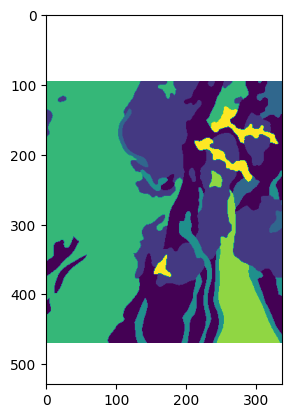

In [23]:
if "DependentSquares" in ti_methods :
    if verbose:
        print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S:%f)') + " <> USING METHOD DEPENDENT SQUARES")
    ti_frame_DS, ntc_DS = gen_ti_frame_squares(nr, nc, ti_pct_area, ti_nshapes, seed)
    ti_list_DS, cd_list_DS, expMax_no_error_DS = build_ti_cd(ti_frame_DS, ntc_DS, sim_var, nc, nr, auxTI_var, auxSG_var, names_var, simgrid_mask_aux, condIm_var)
    expMax = max(expMax_no_error_DS, expMax)
    ti_list.extend(ti_list_DS)
    cd_list.extend(cd_list_DS)
    simgrid_mask = simgrid_mask_aux
    cc_sg, rr_sg = nc, nr
    if saveMask:
        plt.imshow(np.ma.masked_array(reference_var, mask=~ti_frame_DS[0].astype(bool)))
        # plot_mask(ti_frame_DS[0],masking_strategy="Dependent Squares")
        # save_mask(
        #     ti_frame_DS[0],
        #     "custom_mask_"+str(arg_aux_vars),
        #     output_directory=arg_output_dir
        # )

In [ ]:
if "IndependentSquares" in ti_methods :
    if verbose:
        print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S:%f)') + " <> USING METHOD INDEPENDENT SQUARES")
    ti_frame_IS, ntc_IS = gen_ti_frame_separatedSquares(nr, nc, ti_pct_area, ti_nshapes, seed)
    ti_list_IS, cd_list_IS, expMax_no_error_IS = build_ti_cd(ti_frame_IS, ntc_IS, sim_var, nc, nr, auxTI_var, auxSG_var, names_var, simgrid_mask_aux, condIm_var)
    expMax = max(expMax_no_error_IS, expMax)
    ti_list.extend(ti_list_IS)
    cd_list.extend(cd_list_IS)
    simgrid_mask = simgrid_mask_aux
    cc_sg, rr_sg = nc, nr
    if saveMask:
        plot_mask(simgrid_mask,masking_strategy="Independent Squares")

In [ ]:
if "Customised" in ti_methods:
    ti_frame_C, ntc_C = gen_ti_frame_custom(nr, nc, custom_mask_path)
    ti_list_C, cd_list_C, expMax_no_error_C = build_ti_cd(ti_frame_C, ntc_C, sim_var, nc, nr, auxTI_var, auxSG_var, names_var, simgrid_mask_aux, condIm_var)
    expMax = max(expMax_no_error_C, expMax)
    ti_list.extend(ti_list_C)
    cd_list.extend(cd_list_C)
    simgrid_mask = simgrid_mask_aux
    cc_sg, rr_sg = nc, nr
    if saveMask:
        plot_mask(ti_frame_C[0],masking_strategy="Customised")

In [ ]:
if "ReducedTiSg" in ti_methods :
    if verbose:
        print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S:%f)') + " <> USING METHOD DEPENDENT REDUCED TI AND SG")
    ti_frame_RTS, ntc_RTS, simgrid_mask_RTS, cc_sg, rr_sg = gen_ti_frame_sg_mask(nr, nc, pct_ti_sg_overlap, pct_sg, pct_ti, cc_sg, rr_sg, cc_ti, rr_ti, seed)
    simgrid_mask_merged = merge_masks(simgrid_mask_RTS, simgrid_mask_aux)
    ti_list_RTS, cd_list_RTS, expMax_no_error4 = build_ti_cd(ti_frame_RTS, ntc_RTS, sim_var, cc_sg, rr_sg, auxTI_var, auxSG_var, names_var, simgrid_mask_merged, condIm_var)
    expMax = max(expMax_no_error4, expMax)
    ti_list.extend(ti_list_RTS)
    cd_list.extend(cd_list_RTS)
    simgrid_mask = None
    if saveMask:
        if verbose:
            print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S:%f)') + " <> UNABLE TO SAVE MASK FOR METHOD REDUCED TI SG AS FUNCTION IS NOT YET IMPLEMENTED")
    

In [ ]:
drawImage2D(ti_list[0],iv=0)
save_plot("aux_var")

In [87]:
nTI = len(ti_list)
names, distance_types = get_unique_names_and_types(names_var, types_var)

outputFlag = []
for name in names:
    outputFlag.append(outputVarFlag[name])

deesse_input = gn.deesseinterface.DeesseInput(
    nx=cc_sg, ny=rr_sg, nz=1,
    sx=1, sy=1, sz=1,
    ox=0, oy=0, oz=0,
    nv=nvar, varname=names,
    TI=ti_list,
    #pdfTI = pdf_ti,
    mask=simgrid_mask,
    dataImage=cd_list,
    distanceType=distance_types,
    nneighboringNode=nvar*[nn],
    distanceThreshold=nvar*[dt],
    maxScanFraction=nTI*[ms],
    outputVarFlag=outputFlag,
    expMax= expMax,
    npostProcessingPathMax=1,
    seed=seed,
    nrealization=numberofmpsrealizations
) 

In [88]:
deesse_output = gn.deesseinterface.deesseRun(deesse_input, nthreads = nthreads, verbose = 2)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
DeeSse run complete

Warnings encountered (4 times in all):
#  1: WARNING 00010: a variable in a training image is not exhaustively informed
#  2: WARNING 00003: training image values of a variable have been rescaled (linearly) to cover the range of conditioning data values


In [89]:
if saveOutput:
    save_simulation(deesse_output, params, output_directory=deesse_output_folder_complete, custom_name="_"+str(arg_aux_vars))

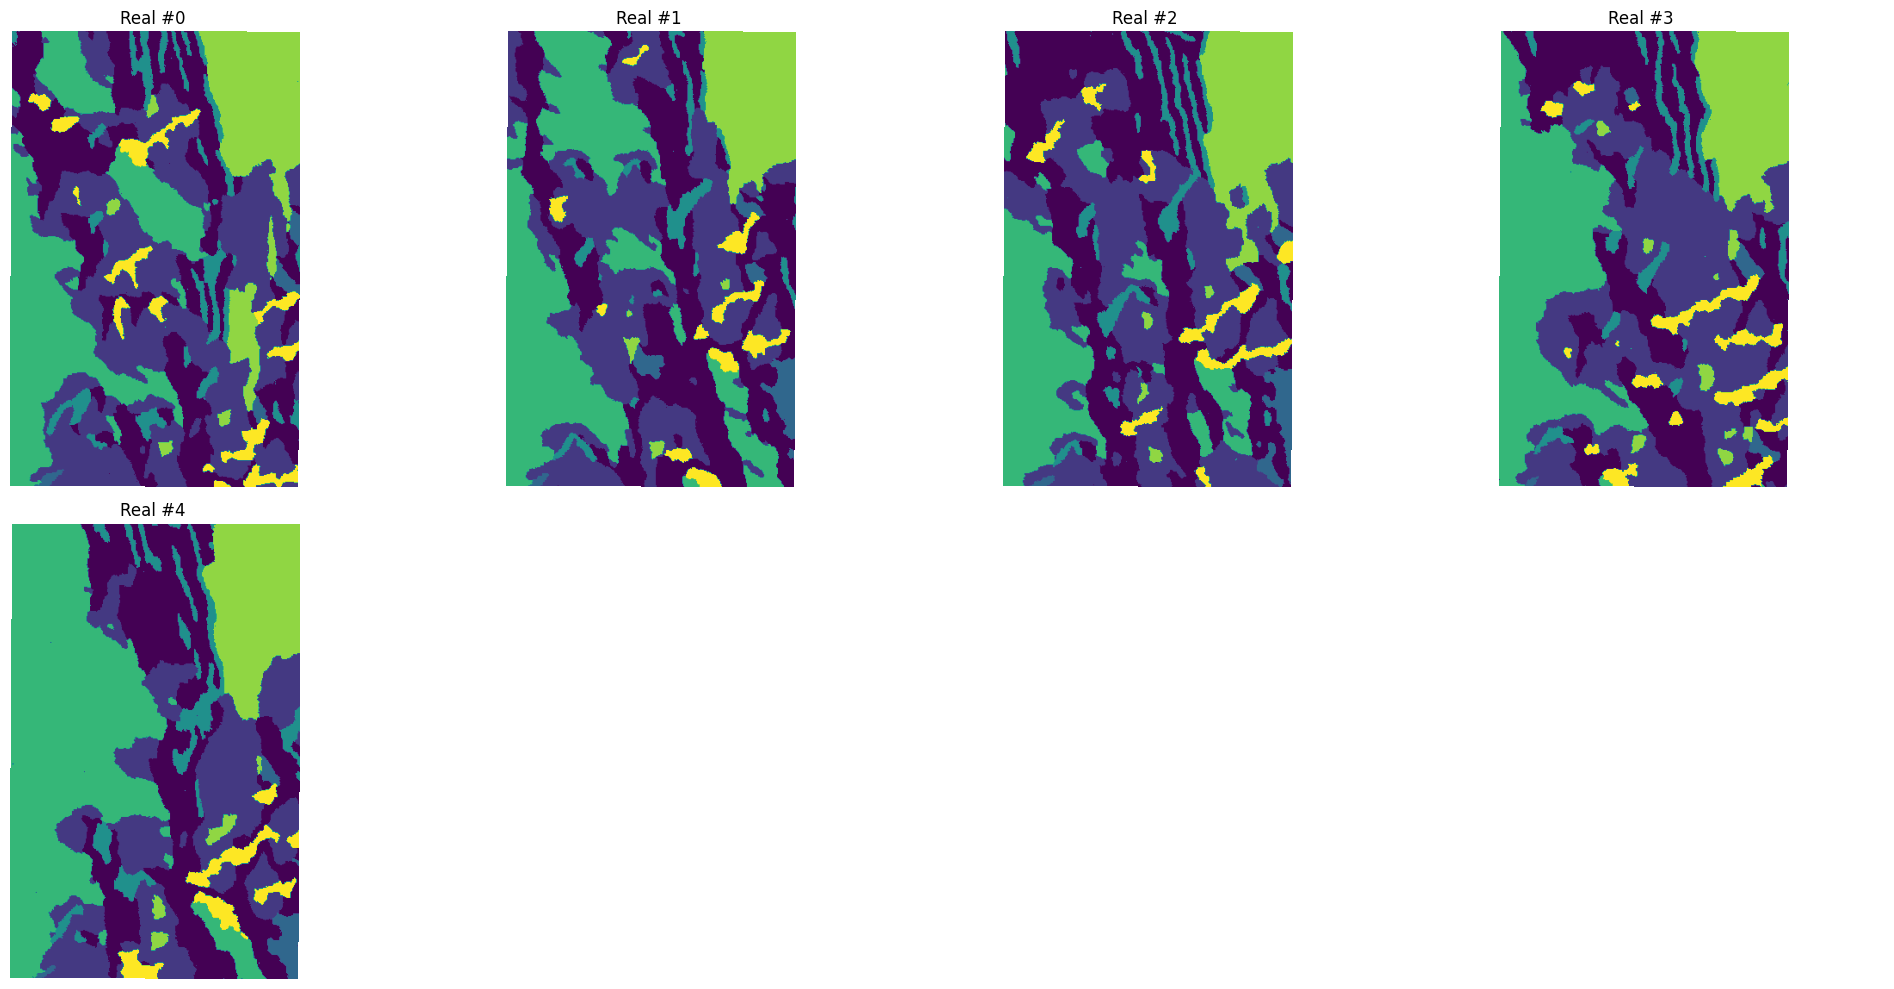

In [90]:
fig = plot_realizations(deesse_output=deesse_output, n_real = 5)
save_plot(fig = fig, fname='desse_output_'+str(arg_aux_vars), output_directory=deesse_output_folder_complete, comments='', params=params)

In [91]:
sim = deesse_output['sim']
all_sim_img = gn.img.gatherImages(sim) #Using the inplace function of geone to gather images
all_sim = all_sim_img.val
all_sim = np.transpose(all_sim,(1,2,3,0))

#CALCULATION OF THE INDICATORS


ent, dist_hist, dist_topo_hamming = calculate_indicators(deesse_output, n_sim_variables=n_sim_variables, reference_var=reference_var)


#CALCULATION OF THE STANDARD DEVIATION
t0_plot = start_timer(f"indicators plotting")
std_ent, realizations_range1 = calculate_std_deviation(ent, 1, numberofmpsrealizations)
std_dist_hist, realizations_range2 = calculate_std_deviation(dist_hist, 1, numberofmpsrealizations)
std_dist_hamming, realizations_range3 = calculate_std_deviation(dist_topo_hamming, 1, numberofmpsrealizations)

if saveIndicators:
    save_indicators(indicators_dict={"ent":ent,
                                    "dist_hist":dist_hist,
                                    "dist_topo_hamming": dist_topo_hamming,
                                    #"std_ent": std_ent,
                                    "std_dist_hist": std_dist_hist,
                                    "std_dist_hamming": std_dist_hamming,
                                    "n_mps_real": numberofmpsrealizations
                                    #f"std_ent_{realizations_range1}": std_ent,
                                    #f"std_dist_hist_{realizations_range2}": std_dist_hist,
                                    #f"std_dist_hamming_{realizations_range3}": std_dist_hamming
                                    },
                    output_directory=plot_output_folder_complete ,#f'output/TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', 
                    comments='',  
                    params={"nsim":nsim})

c:\Users\Axel (Travail)\.conda\envs\PythonEnvGeoclassifMPS\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Axel (Travail)\.conda\envs\PythonEnvGeoclassifMPS\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Axel (Travail)\.conda\envs\PythonEnvGeoclassifMPS\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


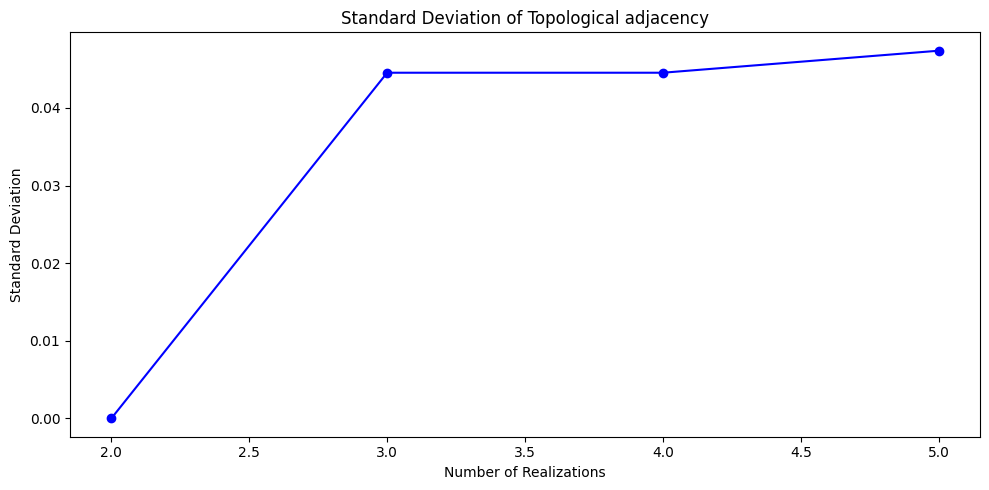

In [92]:
#1 ENTROPY
plot_entropy(ent, background_image=reference_var, categ_var_name="Lithofacies")
save_plot(fname=prefix_entropy+f"_SEED{seed}_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})

#2 HISTOGRAM DISSIMILARITY
plot_histogram_dissimilarity(dist_hist, nsim, referenceIsPresent=True)
save_plot(fname=prefix_histogram_dissimilarity+f"_SEED{seed}_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})

#3 HISTOGRAMS
plot_simvar_histograms(all_sim, nsim)
save_plot(fname=prefix_simvar_histograms+f"_SEED{seed}_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})

#4 TOPOLOGICAL ADAJCENCY
plot_topological_adjacency(dist_topo_hamming, nsim, referenceIsPresent=True)
save_plot(fname=prefix_topological_adjacency+f"_SEED{seed}_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})

#5 PROPORTIONS
plot_proportions(sim)
save_plot(fname=prefix_proportions+f"_SEED{seed}_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})

#6 STANDARD DEVIATON
plot_standard_deviation(std_ent, realizations_range1, indicator_name="Entropy")
save_plot(fname=prefix_std_deviation+f"_entropy_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'entropy_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})
plot_standard_deviation(std_dist_hist, realizations_range2, indicator_name="Jensen Shanon divergence")
save_plot(fname=prefix_std_deviation+f"_dist_histogram_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'dist_histogram_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})
plot_standard_deviation(std_dist_hamming, realizations_range3, indicator_name="Topological adjacency")
save_plot(fname=prefix_std_deviation+f"_dist_topo_hamming_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}.png", output_directory=plot_output_folder_complete, comments=f'dist_topo_hamming_TIPCT{ti_pct_area}-TINSHP{ti_nshapes}-{aux_var_names}', params={"nsim":nsim})
